# CS 4820
# Tutorial 11: Time Series and Recurrent Neural Networks (RNN)



### 1. Time series forecasting

A time series can have arbitrary length, and it usually comes with a timestamp, indicating the absolute time of each sample.

Let's load a dataset that contains hourly electricity demands for different parts of Canada and it runs from May 2003 to December 2016. We will see how recurrent networks can help in this case.

In [1]:
# allow multiple outputs be displayed for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 1.1 Load the data

In [2]:
# Local Jupyter Notebook
fname = './data/ZonalDemands_2003-2016.csv.bz2'

# Google colab : Importing the dataset
# from google.colab import files
# import io

# fname = files.upload()

In [3]:
df = pd.read_csv(fname, compression='bz2',
                 engine='python')


# Google colab : Read the dataset
# df = pd.read_csv("ZonalDemands_2003-2016.csv.bz2", compression='bz2',
#                 engine='python')

df.head(3)
df.tail(3)

,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
0,01-May-03,1,13702,809,1284,965,765,4422,622,41,2729,617,1611,13865,163
1,01-May-03,2,13578,825,1283,923,752,4340,602,43,2731,615,1564,13678,100
2,01-May-03,3,13411,834,1277,910,751,4281,591,45,2696,596,1553,13534,123


,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
119853,2016/12/31,22,15195,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,595
119854,2016/12/31,23,14758,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,032"
119855,2016/12/31,24,14153,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,637"


#### 1.2 Generate the `DatetimeIndex` for each column
Let's create a `pd.DatetimeIndex` using the Date and Hour columns.

In [4]:
def combine_date_hour(row):
    date = pd.to_datetime(row['Date'])
    hour = pd.Timedelta("%d hours" % row['Hour'])
    return date + hour

idx = df.apply(combine_date_hour, axis=1)
idx.head()

0   2003-05-01 01:00:00
1   2003-05-01 02:00:00
2   2003-05-01 03:00:00
3   2003-05-01 04:00:00
4   2003-05-01 05:00:00
dtype: datetime64[ns]

In [5]:
df = df.set_index(idx)

df.head(3)
df.tail(3)

,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
2003-05-01 01:00:00,01-May-03,1,13702,809,1284,965,765,4422,622,41,2729,617,1611,13865,163
2003-05-01 02:00:00,01-May-03,2,13578,825,1283,923,752,4340,602,43,2731,615,1564,13678,100
2003-05-01 03:00:00,01-May-03,3,13411,834,1277,910,751,4281,591,45,2696,596,1553,13534,123


,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
2016-12-31 22:00:00,2016/12/31,22,15195,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,595
2016-12-31 23:00:00,2016/12/31,23,14758,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,032"
2017-01-01 00:00:00,2016/12/31,24,14153,495,1476,1051,1203,5665,1045,72,2986,465,1334,15790,"1,637"


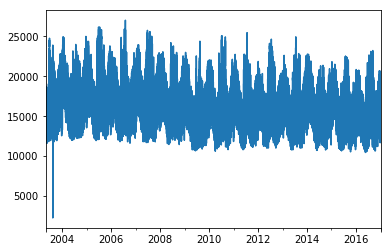

In [6]:
df['Total Ontario'].plot()

#### 1.3 Split the data into training and testing datasets

The time series seems quite regular, which looks promising for forecasting. Let's split the data in time on January 1st, 2014. We will use data before that date as training data and data after that date as test data.

In the rest of this tutorial, we will be working on the electricity demands for `Total Ontario` only.

In [7]:
split_date = pd.Timestamp('01-01-2014')

In [8]:
train = df.loc[:split_date, ['Total Ontario']].copy()
test = df.loc[split_date:, ['Total Ontario']].copy()

In [9]:
train.head(3)
train.tail(3)

test.head(3)
test.tail(3)

,Total Ontario
2003-05-01 01:00:00,13702
2003-05-01 02:00:00,13578
2003-05-01 03:00:00,13411


,Total Ontario
2013-12-31 22:00:00,17572
2013-12-31 23:00:00,16966
2014-01-01 00:00:00,16385


,Total Ontario
2014-01-01 00:00:00,16385
2014-01-01 01:00:00,15862
2014-01-01 02:00:00,15462


,Total Ontario
2016-12-31 22:00:00,15195
2016-12-31 23:00:00,14758
2017-01-01 00:00:00,14153


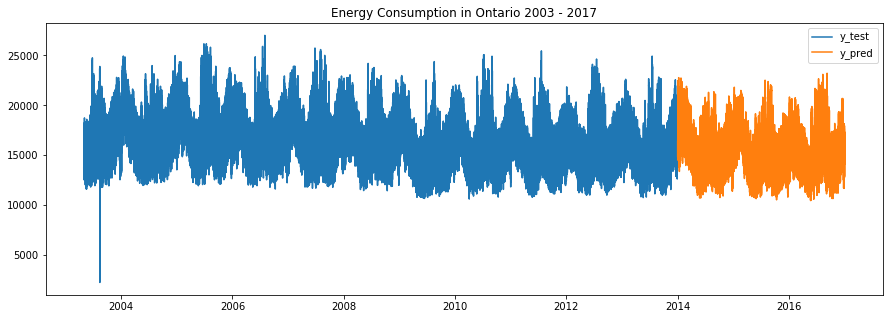

In [10]:
plt.figure(figsize=(15,5))
plt.plot(train, label='y_test')
plt.plot(test, label='y_pred')
plt.legend()
plt.title("Energy Consumption in Ontario 2003 - 2017");

We've already seen so far, the Neural Network models are quite sensitive to the absolute size of the input features. Passing features with very large or minimal values will not help our model converge to a solution. Hence, we should rescale the data before anything else.

In [11]:
offset = 10000
scale = 5000

train_sc = (train - offset) / scale
test_sc = (test - offset) / scale

In [12]:
train_sc[:4]

,Total Ontario
2003-05-01 01:00:00,0.7404
2003-05-01 02:00:00,0.7156
2003-05-01 03:00:00,0.6822
2003-05-01 04:00:00,0.7002


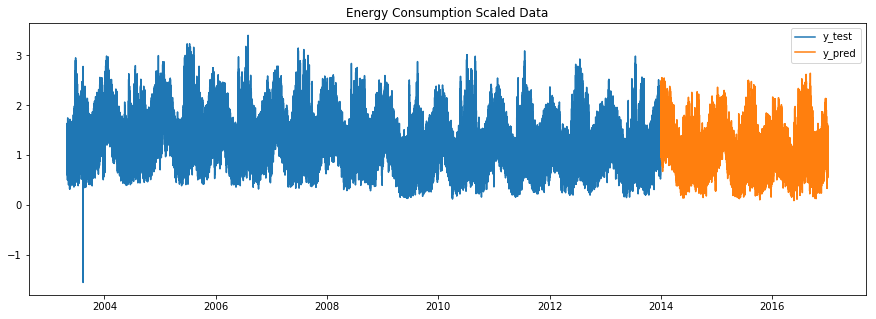

In [13]:
plt.figure(figsize=(15,5))
plt.plot(train_sc, label='y_test')
plt.plot(test_sc, label='y_pred')
plt.legend()
plt.title("Energy Consumption Scaled Data");

#### 1.4 Creating the targets

We are finally ready to build a predictive model. Our target is going to be the value of the energy demand at a certain point in time and our first model will try to predict such value from the value in the preceding hour. Our model will thus only have one feature, and the labels will come from the same data, __shifted in time by one hour__.

There is a neat trick to generate both labels and features from the same `train_sc` timeseries. This is achieved by taking every single point in the timeseries except the last one as features:

In [14]:
X_train = train_sc[:-1].values
y_train = train_sc[1:].values


X_test = test_sc[:-1].values
y_test = test_sc[1:].values

As you can see below, the first value in `y_train` corresponds to the second value in `X_train`, meaning that we will be using the first value `X_train` to predict the next value and so on. Now we have our training data as well as testing data mapped out. Let's move on to model building.

In [15]:
X_train[:5]
y_train[:5]

array([[0.7404],
       [0.7156],
       [0.6822],
       [0.7002],
       [0.802 ]])

array([[0.7156],
       [0.6822],
       [0.7002],
       [0.802 ],
       [1.0226]])

### 2. Fully-Connected Neural Networks Model

Let's train a fully connected network to predict and see that it is not able to predict the next value from the previous one.

The network will have a single input (the previous hour value) and a single output.

Since we want to predict a continuous variable, the output of the network does not need an activation function, and we will use the mean_squared_error as loss function, which is a standard error metric in regression models.

Let's clear the backend of any held memory first before building a new model:

In [16]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

K.clear_session()

#### 2.1 Model construction

In [17]:
model = Sequential([
    Dense(24, input_dim=1, activation='relu'),
    Dense(12, activation='relu'),
    Dense(6, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In this case, before fitting the built Neural Networks, we load the `EarlyStopping` callback, to halt the training if it is not improving.

>TIP: a [callback](https://keras.io/callbacks/) is a set of functions to be applied at each epoch during the training. You can pass a list of callbacks to the `.fit()` method, and in this specific case we use the `EarlyStopping` callback to stop the training if there is no progress. According to the [documentation](https://keras.io/callbacks/), `monitor` defines the quantity to be monitored (the `mean_squared_error` in this case) and `patience` defines the number of epochs with no improvement after which it will stop the training.

In particular, we will set the `EarlyStopping` callback to monitor the value of the loss and stop the training loop with a `patience=3` if that does not improve. Without this callback, the training will plateau on a fixed loss without improving, and the training will not stop by itself (go ahead and try to confirm that!).

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
early_stop = EarlyStopping(monitor='loss',
                           patience=3,
                           verbose=1)

In [20]:
model.fit(X_train, y_train, epochs=200,
          batch_size=512, verbose=0,
          callbacks=[early_stop])

Epoch 00011: early stopping


The model stopped improving quite quickly. Feel free to experiment with other architectures and other activation functions. Let's see how our model is doing. We can generate the predictions on the test set by running `model.predict`.

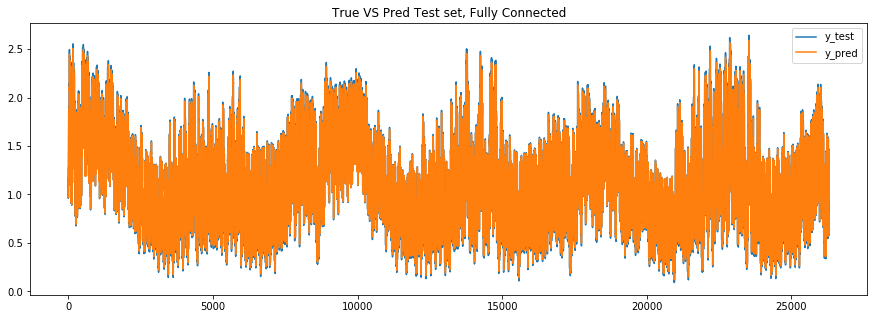

In [21]:
y_pred = model.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.title("True VS Pred Test set, Fully Connected");

They seem to overlap pretty well. Is it so? Let's zoom in and watch more closely. We will do this by using the `plt.xlim` function that sets the boundaries of the horizontal axis in a plot. Feel free to choose other values to inspect other regions of the plot. Also, notice that we lost the date labels when we created the data, but this is not a problem: we can always bring them back from the original series if we need them.

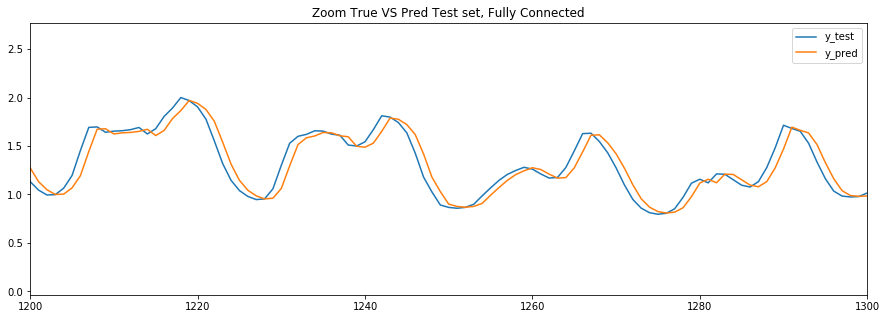

In [22]:
plt.figure(figsize=(15,5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, Fully Connected");

#### 2.2 Model evaluation

Is this a good model? At first glance, we may be tempted to say it is.

__However, the model is not good at all!__

Why do we say that the model is not good at all? If you scrutinize the graph, you will realize that the network has just learned to repeat the same value it receives in input!

This is not forecasting at all. In other words, the model has no real predictive power. It behaves like a parrot that repeats yesterday's value for today. In this particular case, since the curve is varying smoothly, the differences between one day and the next are small. However, the model is not anticipating any future value, and so it would be quite useless for forecasting. One easy way to see this is to measure the correlation between the predicted values and the correct labels, and then repeat the measure of  __<span style="color:red">correlation with labels shifted in time</span>__.

__If the model was good at forecasting we expect the highest correlation to happen for a zero shift, with decreasing correlation when we shift the labels either forward or backward in time__. Let's plug our test data into Pandas Series:

In [23]:
y_test_s = pd.Series(y_test.ravel())
y_pred_s = pd.Series(y_pred.ravel())

In [24]:
for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.63
Shift: -4, Corr: 0.76
Shift: -3, Corr: 0.88
Shift: -2, Corr: 0.97
Shift: -1, Corr: 1.0
Shift:  0, Corr: 0.97
Shift:  1, Corr: 0.88
Shift:  2, Corr: 0.76
Shift:  3, Corr: 0.63
Shift:  4, Corr: 0.5


As you can see, the highest correlation for this model is found for a shift of -1, which validates our previous interpretation. __<span style="color:red">The model is simply copying the input value to the output.<span>__

This behavior is not surprising. After all, the only feature our model knew was the value of the time series in the previous period, so it makes sense that the best it could do was to learn to repeat it as a prediction for what would come next.

Let's see if a recurrent network improves the situation.

### 3. Vanilla Recurrent Neural Networks (RNN) Model

#### 3.1 Reshape the data

The [documentation](https://keras.io/layers/recurrent/) for recurrent layers reads:

    Input shape

    3D tensor with shape (batch_size, timesteps, input_dim).

however, so far we have used only a tensor of second order for our data. Let's think about how to reshape our data because there's more than one way. Our input data right now has a shape of:

In [25]:
X_train.shape

(93551, 1)

So it's like a matrix with a single column. We want to add a dimension to the tensor so that the data is a tensor of order three. There are many ways of doing this, the simplest way is to reshape the tensor using the `.reshape` method. It's as if we were breaking our timeseries into a dataset of adjacent and disjoint windows and then pile all of them one on top of the other.

Let's define the window length to be 128 hours (a little over five days):

In [26]:
win_len = 128

Now we define a helper function that reshapes the data into a tensor of order three. Notice that this function will pre-pad our sequence with zeros since we need to make sure that the total length is divisible by `win_len`:

In [27]:
def reshape_tensor(x, l):
    orig_len = x.shape[0]
    n, r = divmod(orig_len, l)
    max_len = l * (n + 1)
    offset = max_len - orig_len
    new_array = np.zeros(max_len)
    new_array[offset:] = x.ravel()
    return new_array.reshape(n + 1, l, 1)

Let's now convert our Train and Test sets by calling the function above:

In [28]:
X_train_t = reshape_tensor(X_train, win_len)
X_test_t = reshape_tensor(X_test, win_len)

y_train_t = reshape_tensor(y_train, win_len)
y_test_t = reshape_tensor(y_test, win_len)

In [29]:
X_train_t.shape

(731, 128, 1)

![reshape.png](./assets/reshape.png)

#### 3.2 Model construction

First of all, let's clear the backend of any held memory first before building a new model:

In [30]:
K.clear_session()

In [31]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import TimeDistributed

In [32]:
model = Sequential()
model.add(SimpleRNN(6,
                    batch_input_shape=(1, win_len, 1),
                    kernel_initializer='ones',
                    return_sequences=True,
                    stateful=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer=Adam(lr=0.0005),
              loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 128, 6)               48        
_________________________________________________________________
time_distributed (TimeDistri (1, 128, 1)               7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


Now we can fit the data. Since we are maintaining states between point, we shall pass the data in order using the `shuffle=False` flag and `batch_size=1`. Also, we run the training for just three epochs. In our experiments this should be sufficient to get decent results:

In [33]:
model.fit(X_train_t, y_train_t,
          epochs=3,
          batch_size=1,
          verbose=1,
          shuffle=False);

Epoch 1/3
731/731 [==============================] - 50s 68ms/sample - loss: 2.8445
Epoch 2/3
731/731 [==============================] - 54s 74ms/sample - loss: 0.3254
Epoch 3/3
731/731 [==============================] - 50s 69ms/sample - loss: 0.1239


#### 3.3 Model evaluation

Let's plot a small part of our predictive model to compare train and test. We will use the Numpy `.ravel()` method to flatten the tensors back into a unidimensional sequence:

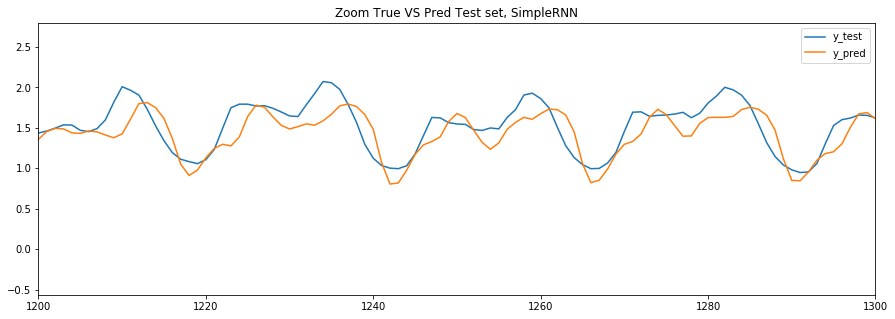

In [34]:
y_pred = model.predict(X_test_t, batch_size=1)
plt.figure(figsize=(15,5))
plt.plot(y_test_t.ravel(), label='y_test')
plt.plot(y_pred.ravel(), label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, SimpleRNN");

While writing the tutorial, I noticed that sometimes the model may converge to different solutions at each training run. 
1. Most often we get a graph that looks a little noisy but it is close to the actual data in the sharp decay phases, meaning some forecasting power is achieved:
![](./assets/simpleRNN_1.png)
2. Sometimes we would get a graph that looks very similar to the Fully Connected result, with no predictivity at all:
![](./assets/simpleRNN.png)
3. Sometimes the network will get stuck and give nonsense results like this one:
![](./assets/simpleRNN_2.png)

Feel free to change the number of layers, nodes, optimizer and learning rate to see if you can get better results. You will notice that this model is very prone to diverging away from a small value of the loss, which is not ideal at all.

Let's also repeat the correlation with time-shift measure:

In [35]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.59
Shift: -4, Corr: 0.75
Shift: -3, Corr: 0.88
Shift: -2, Corr: 0.94
Shift: -1, Corr: 0.93
Shift:  0, Corr: 0.87
Shift:  1, Corr: 0.76
Shift:  2, Corr: 0.63
Shift:  3, Corr: 0.49
Shift:  4, Corr: 0.35


All in all this model seems a little unstable. The problem probably lies with the fact that the `SimpleRNN` actually has a short memory and cannot learn long-term patterns. More importantanly, it suffers from the __"Vanishing Gradient"__ problem as described in the "5. RNN Intuition" slides. 

### 4. Long Short Term Memory (LSTM) Neural Networks Model

In this section, we will replace `SimpleRNN` with `LSTM` when building our model. 

Additionally, we will  improve the model in the following three ways:

- (In section 4.1) Data samples should overlap for better use of the training data
    - Consequently, (In section 4.2), no need to use the `stateful=True` option for the LSTM model
- (In section 4.2) Each LSTM neuron only produces one output (the last one in the time sequence).
    - No need to use the `return_sequences=True` option for the LSTM model
    - No need to use the `TimeDistributed` wrapper
- (In section 4.2) Train our model using a batch of size 256 instead of 1 for faster training 

#### 4.1 Rolling windows

![Rolling windows](./assets/rolling_windows.png)

Let's start by defining a smaller window size. We'll take a window of 24 periods, i.e., the data from the previous day. You can always adjust this later on if you wish:

In [36]:
window_len = 24

Next, we define a helper function `create_lagged_Xy_win` to create the lagged data:

In [37]:
def create_lagged_Xy_win(data, start_lag=1,
                         window_len=1):
    X = data.shift(start_lag + window_len - 1).copy()
    X.columns = ['T_{}'.format(start_lag + window_len - 1)]

    if window_len > 1:
        for s in range(window_len, 0, -1):
            col_ = 'T_{}'.format(start_lag + s - 1)
            X[col_] = data.shift(start_lag + s - 1)

    X = X.dropna()
    idx = X.index
    y = data.loc[idx]
    return X, y

Now we use the function on the train and test data. We will use `start_lag=1` so that we can compare the results with our previous results:

In [38]:
start_lag=1

X_train, y_train = create_lagged_Xy_win(train_sc,
                                        start_lag,
                                        window_len)

X_test, y_test = create_lagged_Xy_win(test_sc,
                                      start_lag,
                                      window_len)

In [39]:
X_train.head()
y_train.head()

,T_24,T_23,T_22,T_21,T_20,T_19,T_18,T_17,T_16,T_15,...,T_10,T_9,T_8,T_7,T_6,T_5,T_4,T_3,T_2,T_1
2003-05-02 01:00:00,0.7404,0.7156,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,...,1.6036,1.6290,1.6096,1.5486,1.5228,1.6008,1.5408,1.3096,1.0414,0.8694
2003-05-02 02:00:00,0.7156,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,...,1.6290,1.6096,1.5486,1.5228,1.6008,1.5408,1.3096,1.0414,0.8694,0.7742
2003-05-02 03:00:00,0.6822,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,...,1.6096,1.5486,1.5228,1.6008,1.5408,1.3096,1.0414,0.8694,0.7742,0.7218
2003-05-02 04:00:00,0.7002,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,1.6236,...,1.5486,1.5228,1.6008,1.5408,1.3096,1.0414,0.8694,0.7742,0.7218,0.6914
2003-05-02 05:00:00,0.8020,1.0226,1.3524,1.5536,1.6074,1.6382,1.6342,1.6242,1.6236,1.5976,...,1.5228,1.6008,1.5408,1.3096,1.0414,0.8694,0.7742,0.7218,0.6914,0.7018


,Total Ontario
2003-05-02 01:00:00,0.7742
2003-05-02 02:00:00,0.7218
2003-05-02 03:00:00,0.6914
2003-05-02 04:00:00,0.7018
2003-05-02 05:00:00,0.7904


Like described in Section 3.1 above, to feed this data to a recurrent model, we need to reshape as a tensor of order with the shape ` (batch_size, timesteps, input_dim)`.

In [40]:
X_train_t = X_train.values.reshape(-1, window_len, 1)
X_test_t = X_test.values.reshape(-1, window_len, 1)

y_train_t = y_train.values
y_test_t = y_test.values

In [41]:
X_train_t.shape

(93528, 24, 1)

#### 4.2 Model construction

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense

K.clear_session()

Build the LSTM model:

- Six neurons 
- `input_shape=(window_len, 1)`. The batch size will be inferred when fitting the model.
- No need to use the `stateful=True` option because some history is already present in the input data and the windows are overlapping (see Section 4.1 above).
- No need to use the `return_sequences=True` option for the model
- No need to use the `TimeDistributed` wrapper for the `Dense` layer

In [43]:
model = Sequential()
model.add(LSTM(6, input_shape=(window_len, 1),
               kernel_initializer='ones'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0005) )

Train the modle:

- 10 epochs
- `batch_size=256`

In [44]:
model.fit(X_train_t, y_train_t,
          epochs=10,
          batch_size=256,
          verbose=1);

Epoch 1/10
93528/93528 [==============================] - 12s 127us/sample - loss: 0.0703
Epoch 2/10
93528/93528 [==============================] - 11s 114us/sample - loss: 0.0183
Epoch 3/10
93528/93528 [==============================] - 10s 110us/sample - loss: 0.0094
Epoch 4/10
93528/93528 [==============================] - 12s 128us/sample - loss: 0.0076
Epoch 5/10
93528/93528 [==============================] - 12s 126us/sample - loss: 0.0068
Epoch 6/10
93528/93528 [==============================] - 12s 129us/sample - loss: 0.0062
Epoch 7/10
93528/93528 [==============================] - 12s 127us/sample - loss: 0.0059
Epoch 8/10
93528/93528 [==============================] - 12s 123us/sample - loss: 0.0056
Epoch 9/10
93528/93528 [==============================] - 12s 126us/sample - loss: 0.0054
Epoch 10/10
93528/93528 [==============================] - 12s 126us/sample - loss: 0.0052


#### 4.3 Model evaluation

Let's plot a small part of our predictive model to compare train and test. __No need to use the `Numpy .ravel()` method though__:

Here is a sample of the plot that is expected:

![LSTM_1](./assets/LSTM_1.png)


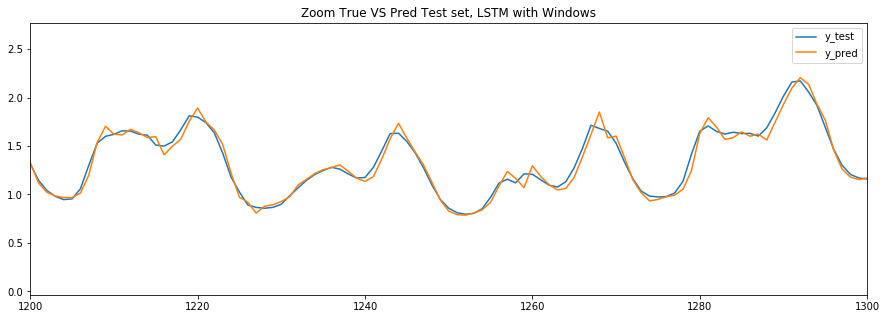

In [45]:
y_pred = model.predict(X_test_t, batch_size=256)
plt.figure(figsize=(15,5))
plt.plot(y_test_t, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.xlim(1200,1300)
plt.title("Zoom True VS Pred Test set, LSTM with Windows");

Let's also repeat the correlation with time-shift measure.

__Ensure the highest correlation to happen for a zero shift, with decreasing correlation when we shift the labels either forward or backward in time.__ 

Here is a sample of the result that is expected:

![LSTM_2](./assets/LSTM_2.png)


In [46]:
y_test_s = pd.Series(y_test_t.ravel())
y_pred_s = pd.Series(y_pred.ravel())

for shift in range(-5, 5):
    y_pred_shifted = y_pred_s.shift(shift)
    corr = y_test_s.corr(y_pred_shifted)
    print("Shift: {:2}, Corr: {:0.2}".format(shift, corr))

Shift: -5, Corr: 0.5
Shift: -4, Corr: 0.63
Shift: -3, Corr: 0.76
Shift: -2, Corr: 0.88
Shift: -1, Corr: 0.97
Shift:  0, Corr: 0.99
Shift:  1, Corr: 0.94
Shift:  2, Corr: 0.84
Shift:  3, Corr: 0.72
Shift:  4, Corr: 0.59


This model trained __considerably faster and more consistent__ than the simpleRNN-based model, and its predictions should look better than the previous models. First of all the model seems to have learned the temporal patter much better than the other models: it's not simply repeating the input like a parrot, it's genuinely trying to predict the future. Also, the curves look quite close to one another, which is a great sign!
